In [1]:
 !nvidia-smi -L

import tensorflow as tf

if tf.test.gpu_device_name():
    print('GPU found')
    device_name = tf.test.gpu_device_name()
else:
    print("No GPU found, using CPU instead")
    device_name = '/cpu:0'

if device_name == '/device:GPU:0':
    print('Found P100 GPU')
else:
    print('Using default device: ', device_name)
    
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9

sess = tf.compat.v1.Session(config=config)

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-e9d8addb-345e-4cf7-5a29-a2c4b3c694bf)
GPU found
Found P100 GPU


In [2]:
# import system libs 
import os
import time
import shutil
import itertools

# import data handling tools 
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [3]:
# Generate data paths with lables 
def define_paths(dir):
    filepaths = []
    labels = []

    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# Conctainate data pathes with lables into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)


# Split data into train, validation, and test
def split_data(tr_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)
    
    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)
    
    return train_df, valid_df, test_df 

In [4]:
def create_model_data (train_df, valid_df, test_df, batch_size):
    
    ''' This function takes train, validation, and test dataframe and fit them into image data generator, because model takes 
         data from image data generator. 
         Image data generator converts images into tensors. '''
    

    # define model parameters
    img_size = (224, 224)
    channels = 3
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)
    
    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    
    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img
    
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)
    
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)
    
    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size) 
    
    
    return train_gen, valid_gen, test_gen

In [5]:
def show_images(gen):
    
    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index} 
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string 
    images, labels = next(gen)        # get a batch size samples from the generator
    
    # calculate number of dispalyed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images
    
    plt.figure(figsize= (20, 20))
    
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'black', fontsize= 12)
    plt.show()

In [6]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, base_model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.base_model = base_model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):       
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights) 


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100 
        loss = logs.get('loss')
        
        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '') 


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss
            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                else:
                    self.count = self.count + 1 # increment the patience counter
                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

#         else:
#             if self.ask_epoch != None and self.ask_permission != 0:
#                 if epoch + 1 >= self.ask_epoch:
#                     msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
#                     print(msg)
#                     ans = input('')
#                     if ans == 'H' or ans == 'h':
#                         msg = f'training has been halted at epoch {epoch + 1} due to user input'
#                         print(msg)
#                         self.model.stop_training = True # stop training
#                     else:
#                         try:
#                             ans = int(ans)
#                             self.ask_epoch += ans
#                             msg = f' training will continue until epoch ' + str(self.ask_epoch)
#                             print(msg)
#                             msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
#                             print(msg)
#                         except:
#                             print('Invalid')

In [7]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()

In [8]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	plt.figure(figsize= (20, 20))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)
	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')
	else:
		print('Confusion Matrix, Without Normalization')
	print(cm)
	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

Found 3582 validated image filenames belonging to 44 classes.
Found 448 validated image filenames belonging to 44 classes.
Found 448 validated image filenames belonging to 44 classes.


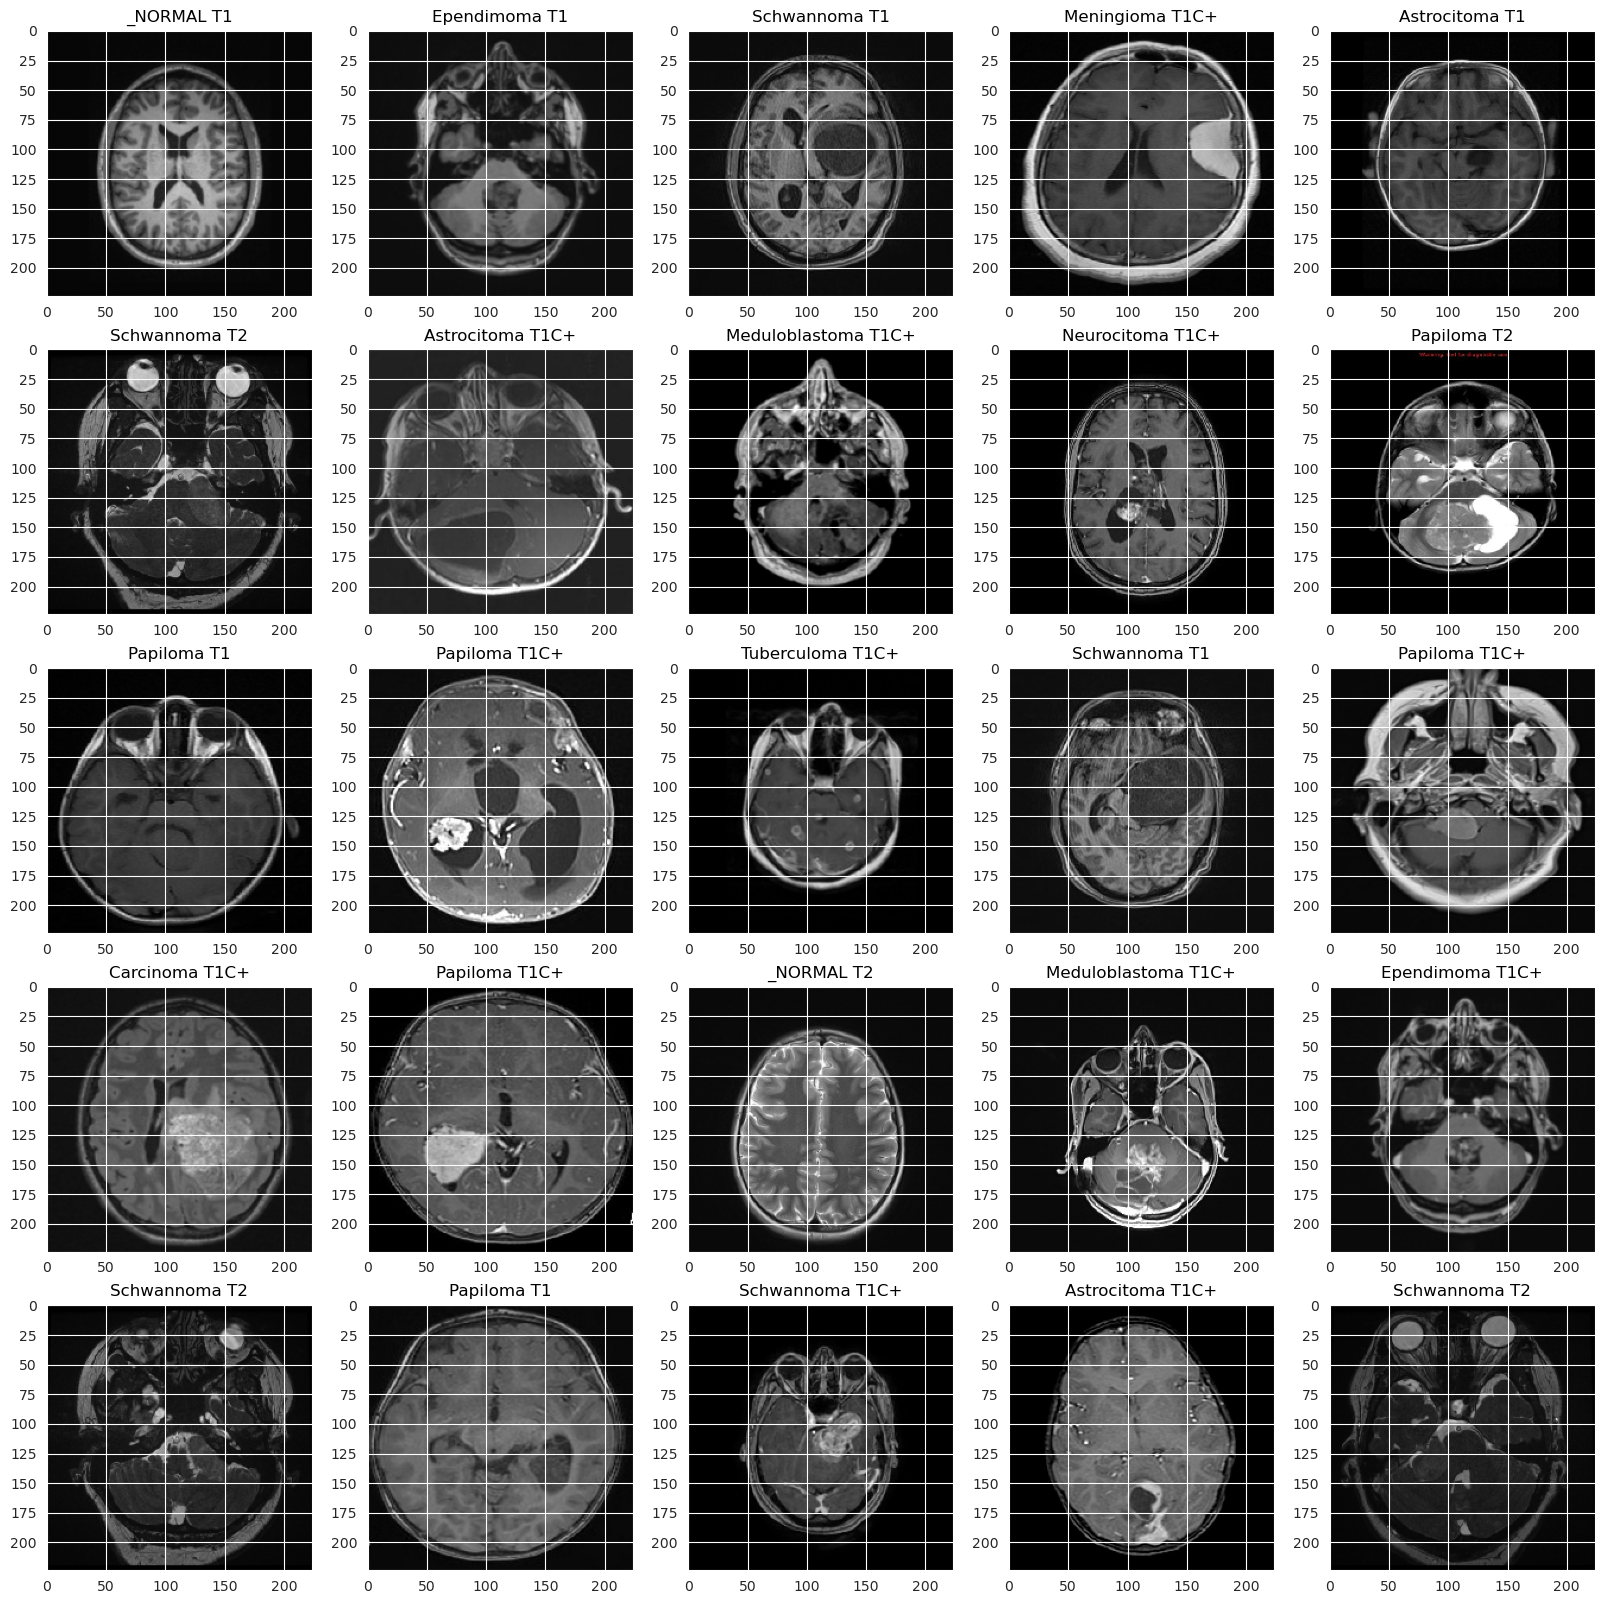

In [9]:
# Get Dataframes
data_dir = '/kaggle/input/brain-tumor-mri-images-44c/'
train_df, valid_df, test_df = split_data(data_dir)

# Get Generators
batch_size = 40
train_gen, valid_gen, test_gen = create_model_data(train_df, valid_df, test_df, batch_size)

# Display Image Samples
show_images(train_gen)

In [10]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 44)                11308     
                                                                 
Total params: 11,194,459
Trainable params: 11,104,084
Non

In [11]:
batch_size = 40     # set batch size for training
epochs = 5         # number of all epochs in training
patience = 1 		    # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3 	# number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9 	  # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor = 0.5 		    # factor to reduce lr by
ask_epoch = 5		    # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= model, base_model= base_model, patience= patience,
            stop_patience= stop_patience, threshold= threshold, factor= factor,
            batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

In [12]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration


2024-03-28 08:25:38.602793: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 1 /5      9.577   39.447   8.29467  53.795   0.00100  0.00100  accuracy     0.00    113.28 
 2 /5      7.008   71.301   6.46146  71.429   0.00100  0.00100  accuracy    80.75    45.67  
 3 /5      5.549   83.975   5.37927  75.000   0.00100  0.00100  accuracy    17.78    45.55  
 4 /5      4.477   90.313   4.37164  82.143   0.00100  0.00100  val_loss    18.73    45.32  
 5 /5      3.646   93.663   3.47970  87.054   0.00100  0.00100  val_loss    20.40    45.84  
training elapsed time was 0.0 hours,  4.0 minutes, 56.65 seconds)


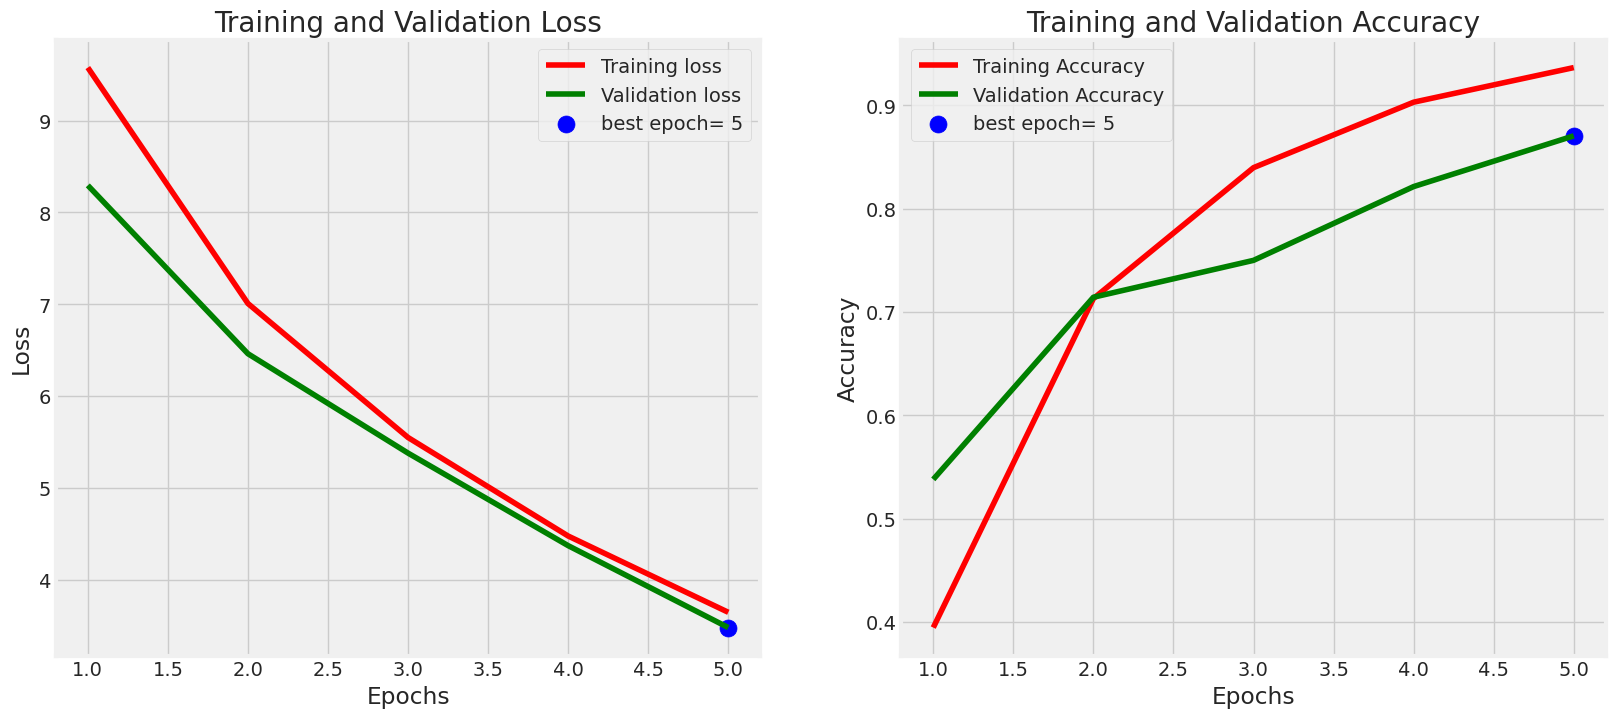

In [13]:
plot_training(history)

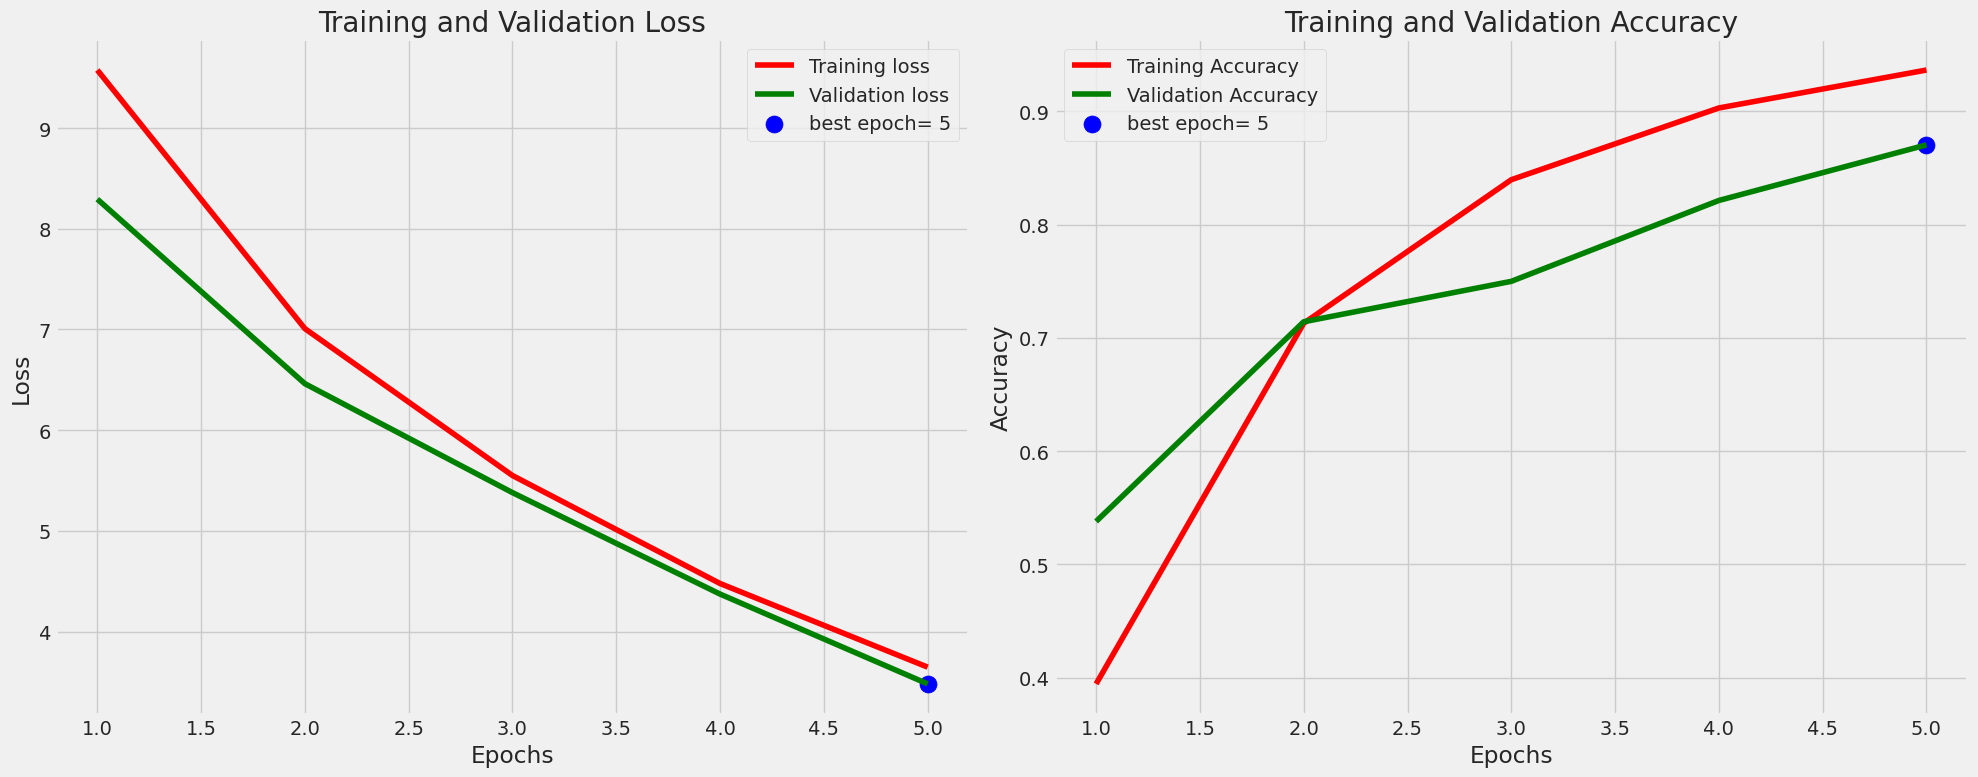

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training(hist, filename):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename, format='png')
    plt.show()
plot_training(history, 'DenseNet201_training_plot.png')

In [15]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

7/7 [==============================] - 4s 468ms/step - loss: 3.4966 - accuracy: 0.8549
Train Loss:  3.194732666015625
Train Accuracy:  0.9678571224212646
--------------------
Validation Loss:  3.4368386268615723
Validation Accuracy:  0.8892857432365417
--------------------
Test Loss:  3.4965598583221436
Test Accuracy:  0.8549107313156128


In [16]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[38 43 25  7 27 43 38 26 26  1 25  1 36 25 25 43 30 34 42 29  0 24 43 28
 25 27 43 30 26 27 16 27 43 42  2 42 24 27 42 43 26 42 26 37 27 40  1 24
 21  1  5 26 26  1 22  8 43  5 43 29 28 25 43 26 25  1  9 16 24 26 37  2
 34 27  2 36  7 36 24 36 24 36 42 28 37 42 18  1 33 25 24 28 42 33 30  1
 17  8 11 34 37 42  3  0 32  5  2 43 26 30  1 26 30  7 28  4 35 26 30 19
 40 25  3 25  1  7 25 28  0 24 25 39  0  0 42 26 24 34 36 41 26 25 36 27
  2  7 33 43 24 37 37  2 33 36 34 26 42 43 25 28 23  1  1 31  0 38 28  1
 24  6 26 24 31  5 43 38 28 37 26  4 27 26  4 16 24 27 40 43 24  8  3  3
 36 13  1 38 29 30 38 28 25  1 33 43 31 24 40 37 36 28 24  2 37 40 25 28
 16 32 29 42 42 29  1  2  1 30 25  0  5  1 38  2 27 40  1  1 43 26  2 25
 36 36 25 25  0 13 25 30  0 43  5  2  4  3  5 28  1 26 34  8 27 24 33 24
 29  0  0 28 18 26 34 34 42 25 29 22 26 36 42 25 43 27 35 42  1 38 21 38
 37 40 35  0 43 10  1 27 42 15  8 34 24 26 41  0 31 24  2 15 26 42 29 26
  1  4 28 25 32 26 43 22 35 15 22 34  4 25 24  0  2

Confusion Matrix, Without Normalization
[[17  1  0 ...  0  0  0]
 [ 1 22  0 ...  0  0  0]
 [ 0  0 15 ...  0  0  1]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  0 24  0]
 [ 0  0  0 ...  0  0 25]]
                        precision    recall  f1-score   support

        Astrocitoma T1       0.85      0.94      0.89        18
      Astrocitoma T1C+       0.76      0.92      0.83        24
        Astrocitoma T2       0.75      0.88      0.81        17
          Carcinoma T1       1.00      0.86      0.92         7
        Carcinoma T1C+       1.00      0.91      0.95        11
          Carcinoma T2       0.86      0.86      0.86         7
         Ependimoma T1       1.00      0.75      0.86         4
       Ependimoma T1C+       0.67      0.80      0.73         5
         Ependimoma T2       0.71      1.00      0.83         5
      Ganglioglioma T1       1.00      0.50      0.67         2
    Ganglioglioma T1C+       1.00      1.00      1.00         2
      Ganglioglioma T2       0.33  

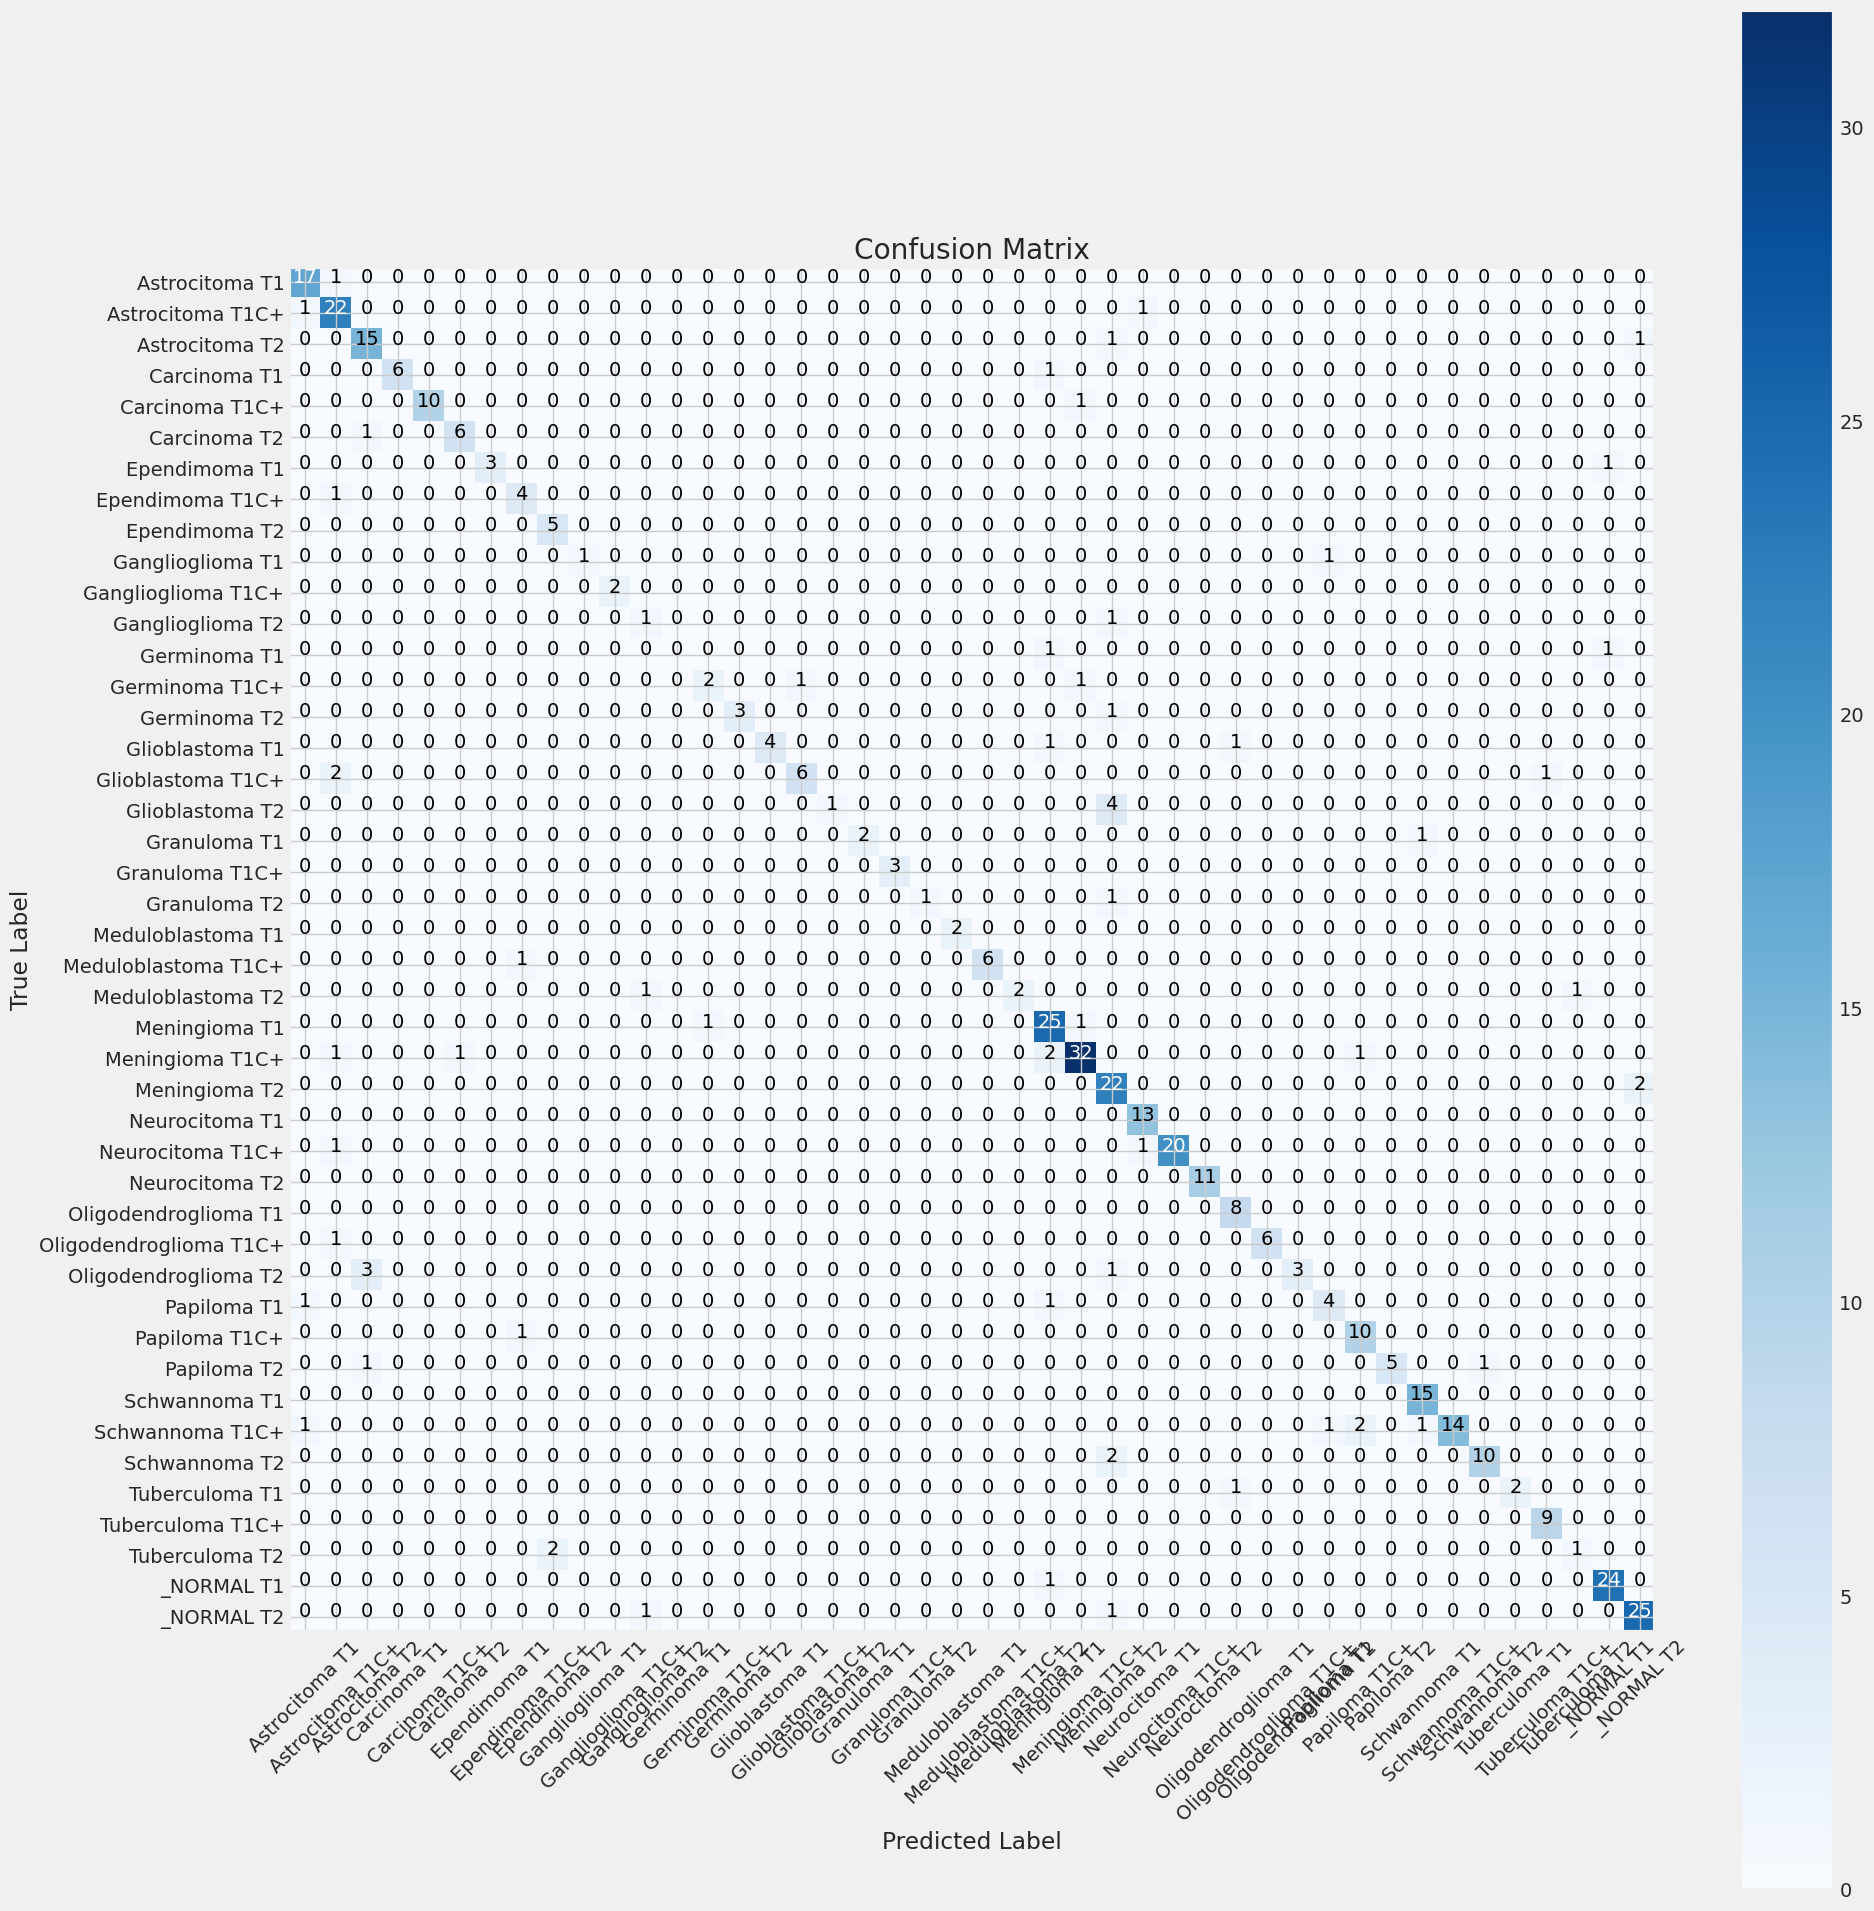

In [17]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

Confusion Matrix, Without Normalization
[[17  1  0 ...  0  0  0]
 [ 1 22  0 ...  0  0  0]
 [ 0  0 15 ...  0  0  1]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  0 24  0]
 [ 0  0  0 ...  0  0 25]]
Confusion Matrix saved as DenseNet201_confusion_matrix.png


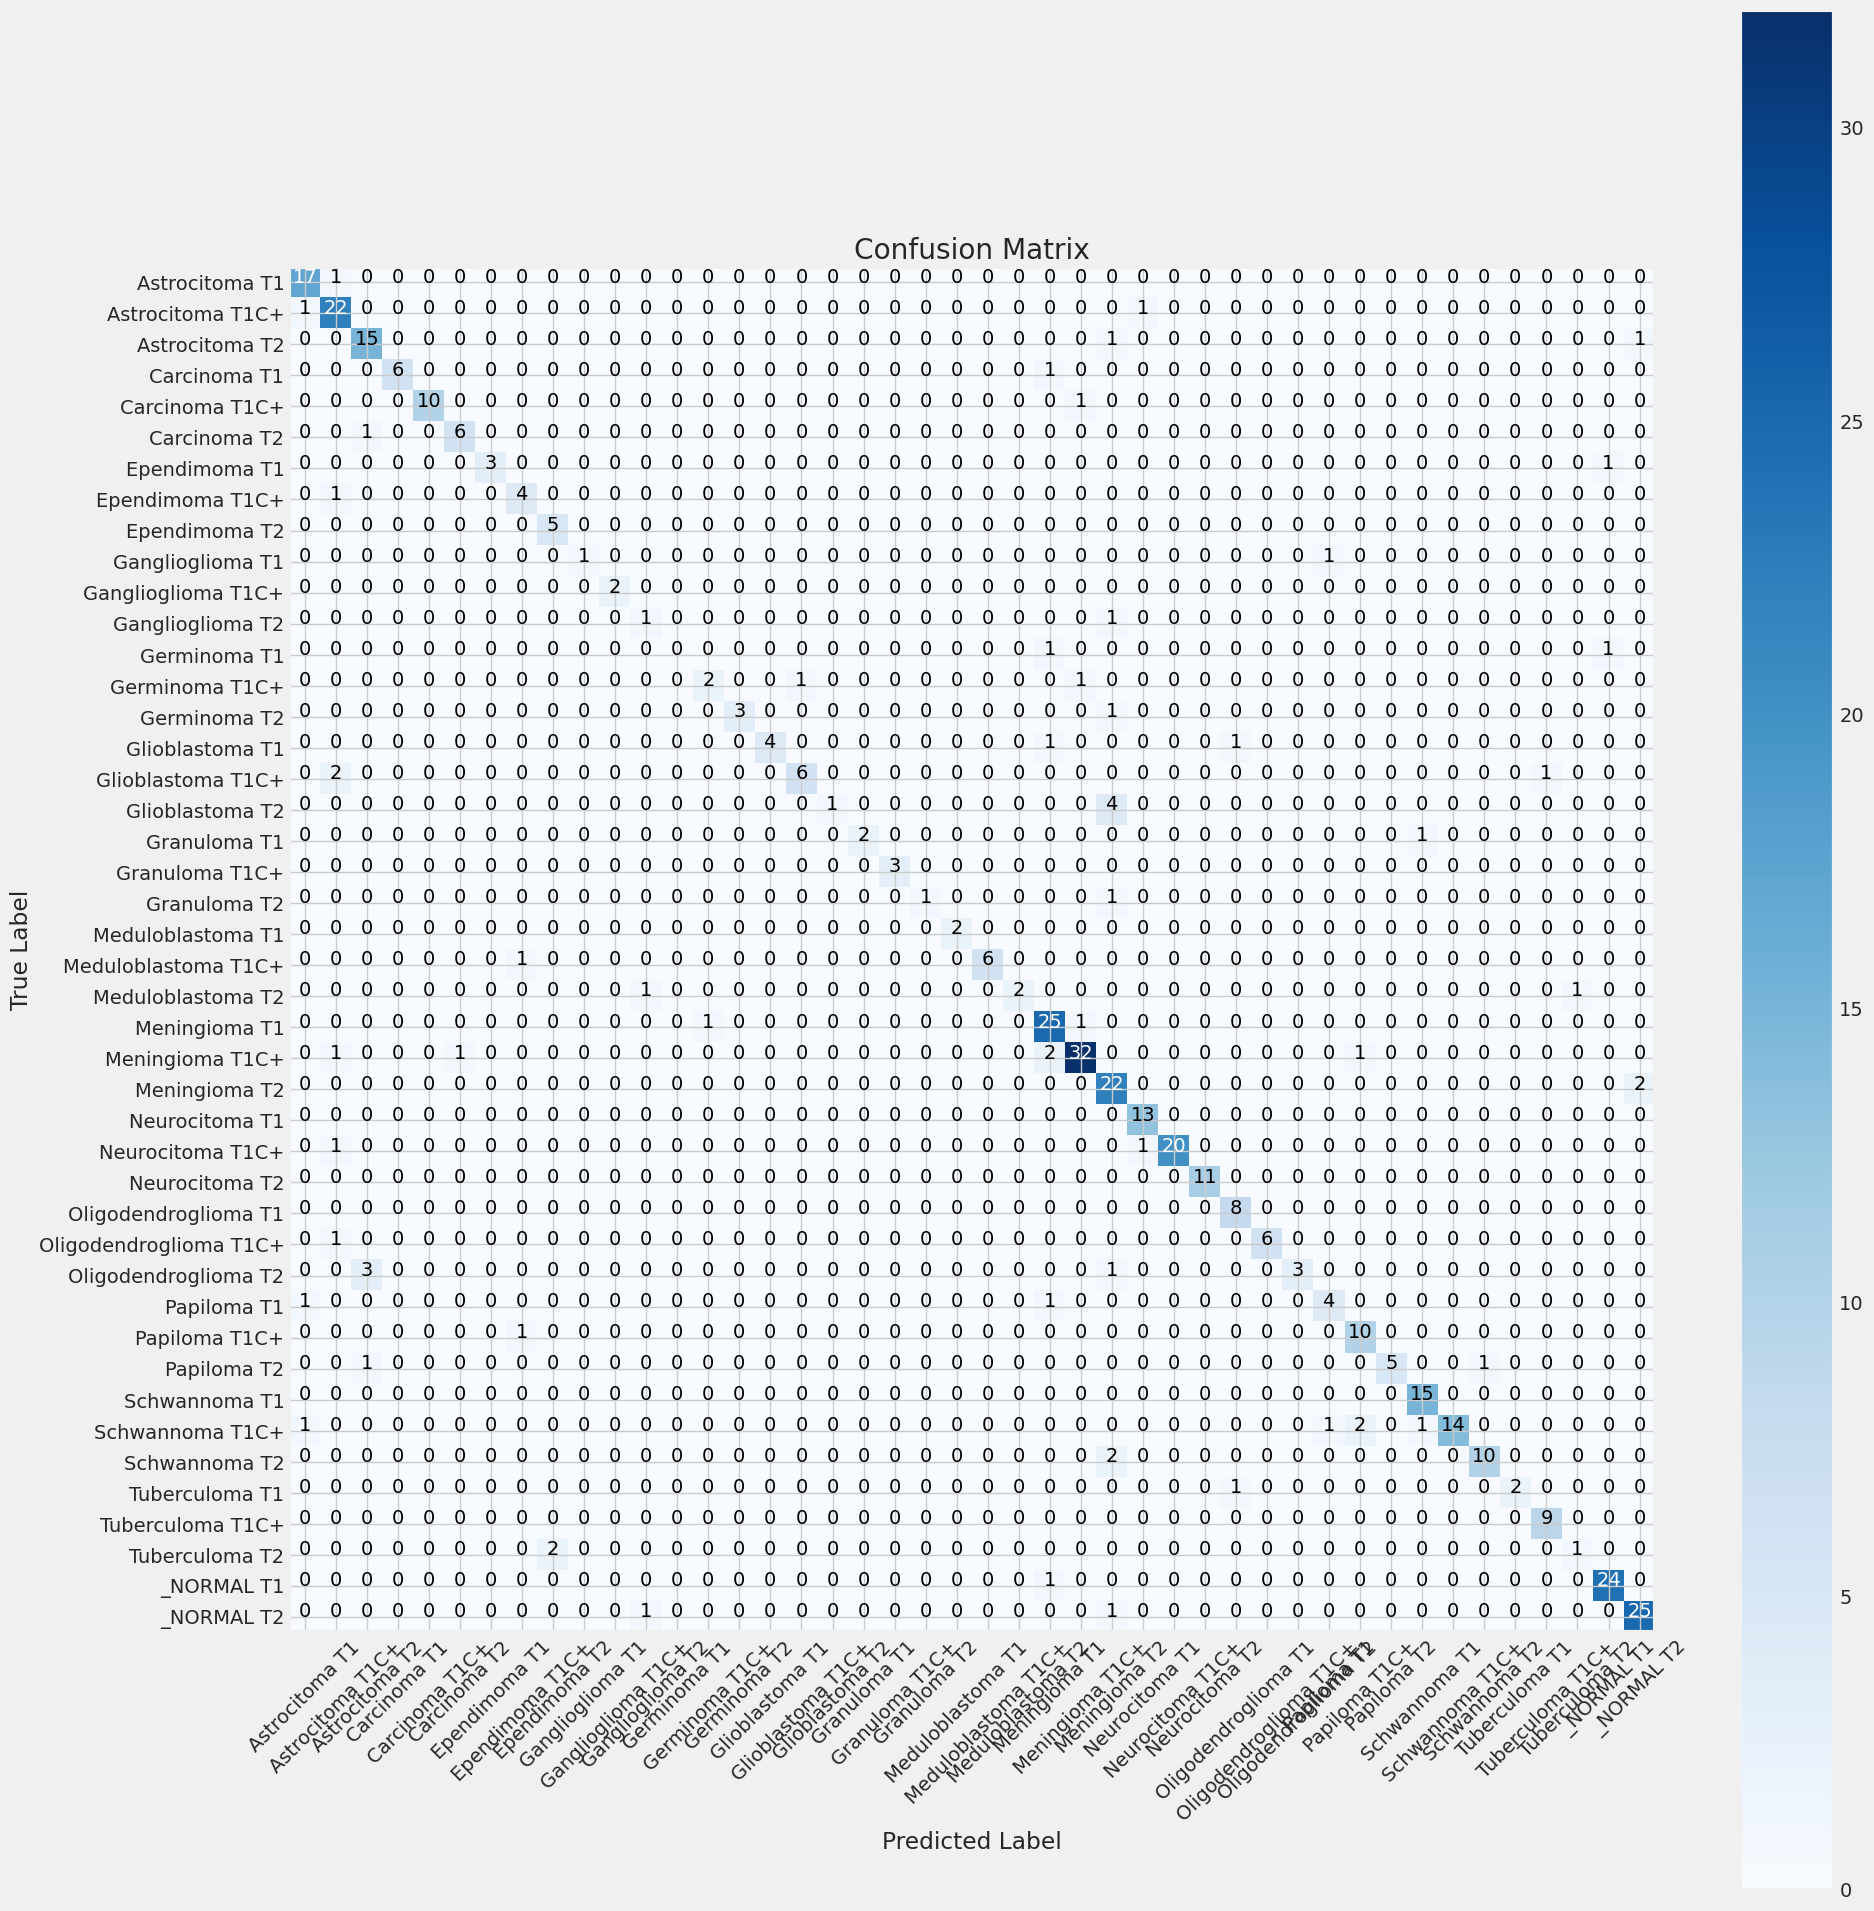

                        precision    recall  f1-score   support

        Astrocitoma T1       0.85      0.94      0.89        18
      Astrocitoma T1C+       0.76      0.92      0.83        24
        Astrocitoma T2       0.75      0.88      0.81        17
          Carcinoma T1       1.00      0.86      0.92         7
        Carcinoma T1C+       1.00      0.91      0.95        11
          Carcinoma T2       0.86      0.86      0.86         7
         Ependimoma T1       1.00      0.75      0.86         4
       Ependimoma T1C+       0.67      0.80      0.73         5
         Ependimoma T2       0.71      1.00      0.83         5
      Ganglioglioma T1       1.00      0.50      0.67         2
    Ganglioglioma T1C+       1.00      1.00      1.00         2
      Ganglioglioma T2       0.33      0.50      0.40         2
          Germinoma T1       0.00      0.00      0.00         2
        Germinoma T1C+       0.67      0.50      0.57         4
          Germinoma T2       1.00      

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues, save_path=None):
    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    if save_path is not None:
        plt.savefig(save_path, format='png')
        print(f"Confusion Matrix saved as {save_path}")
    plt.show()


# Example usage:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Compute confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

# Plot and save confusion matrix as PNG
save_path = 'DenseNet201_confusion_matrix.png'
plot_confusion_matrix(cm=cm, classes=classes, title='Confusion Matrix', save_path=save_path)

# Print classification report
print(classification_report(test_gen.classes, y_pred, target_names=classes))

Confusion Matrix, Without Normalization
[[17  1  0 ...  0  0  0]
 [ 1 22  0 ...  0  0  0]
 [ 0  0 15 ...  0  0  1]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  0 24  0]
 [ 0  0  0 ...  0  0 25]]
                        precision    recall  f1-score     support
Astrocitoma T1           0.850000  0.944444  0.894737   18.000000
Astrocitoma T1C+         0.758621  0.916667  0.830189   24.000000
Astrocitoma T2           0.750000  0.882353  0.810811   17.000000
Carcinoma T1             1.000000  0.857143  0.923077    7.000000
Carcinoma T1C+           1.000000  0.909091  0.952381   11.000000
Carcinoma T2             0.857143  0.857143  0.857143    7.000000
Ependimoma T1            1.000000  0.750000  0.857143    4.000000
Ependimoma T1C+          0.666667  0.800000  0.727273    5.000000
Ependimoma T2            0.714286  1.000000  0.833333    5.000000
Ganglioglioma T1         1.000000  0.500000  0.666667    2.000000
Ganglioglioma T1C+       1.000000  1.000000  1.000000    2.000000
Gangliogliom

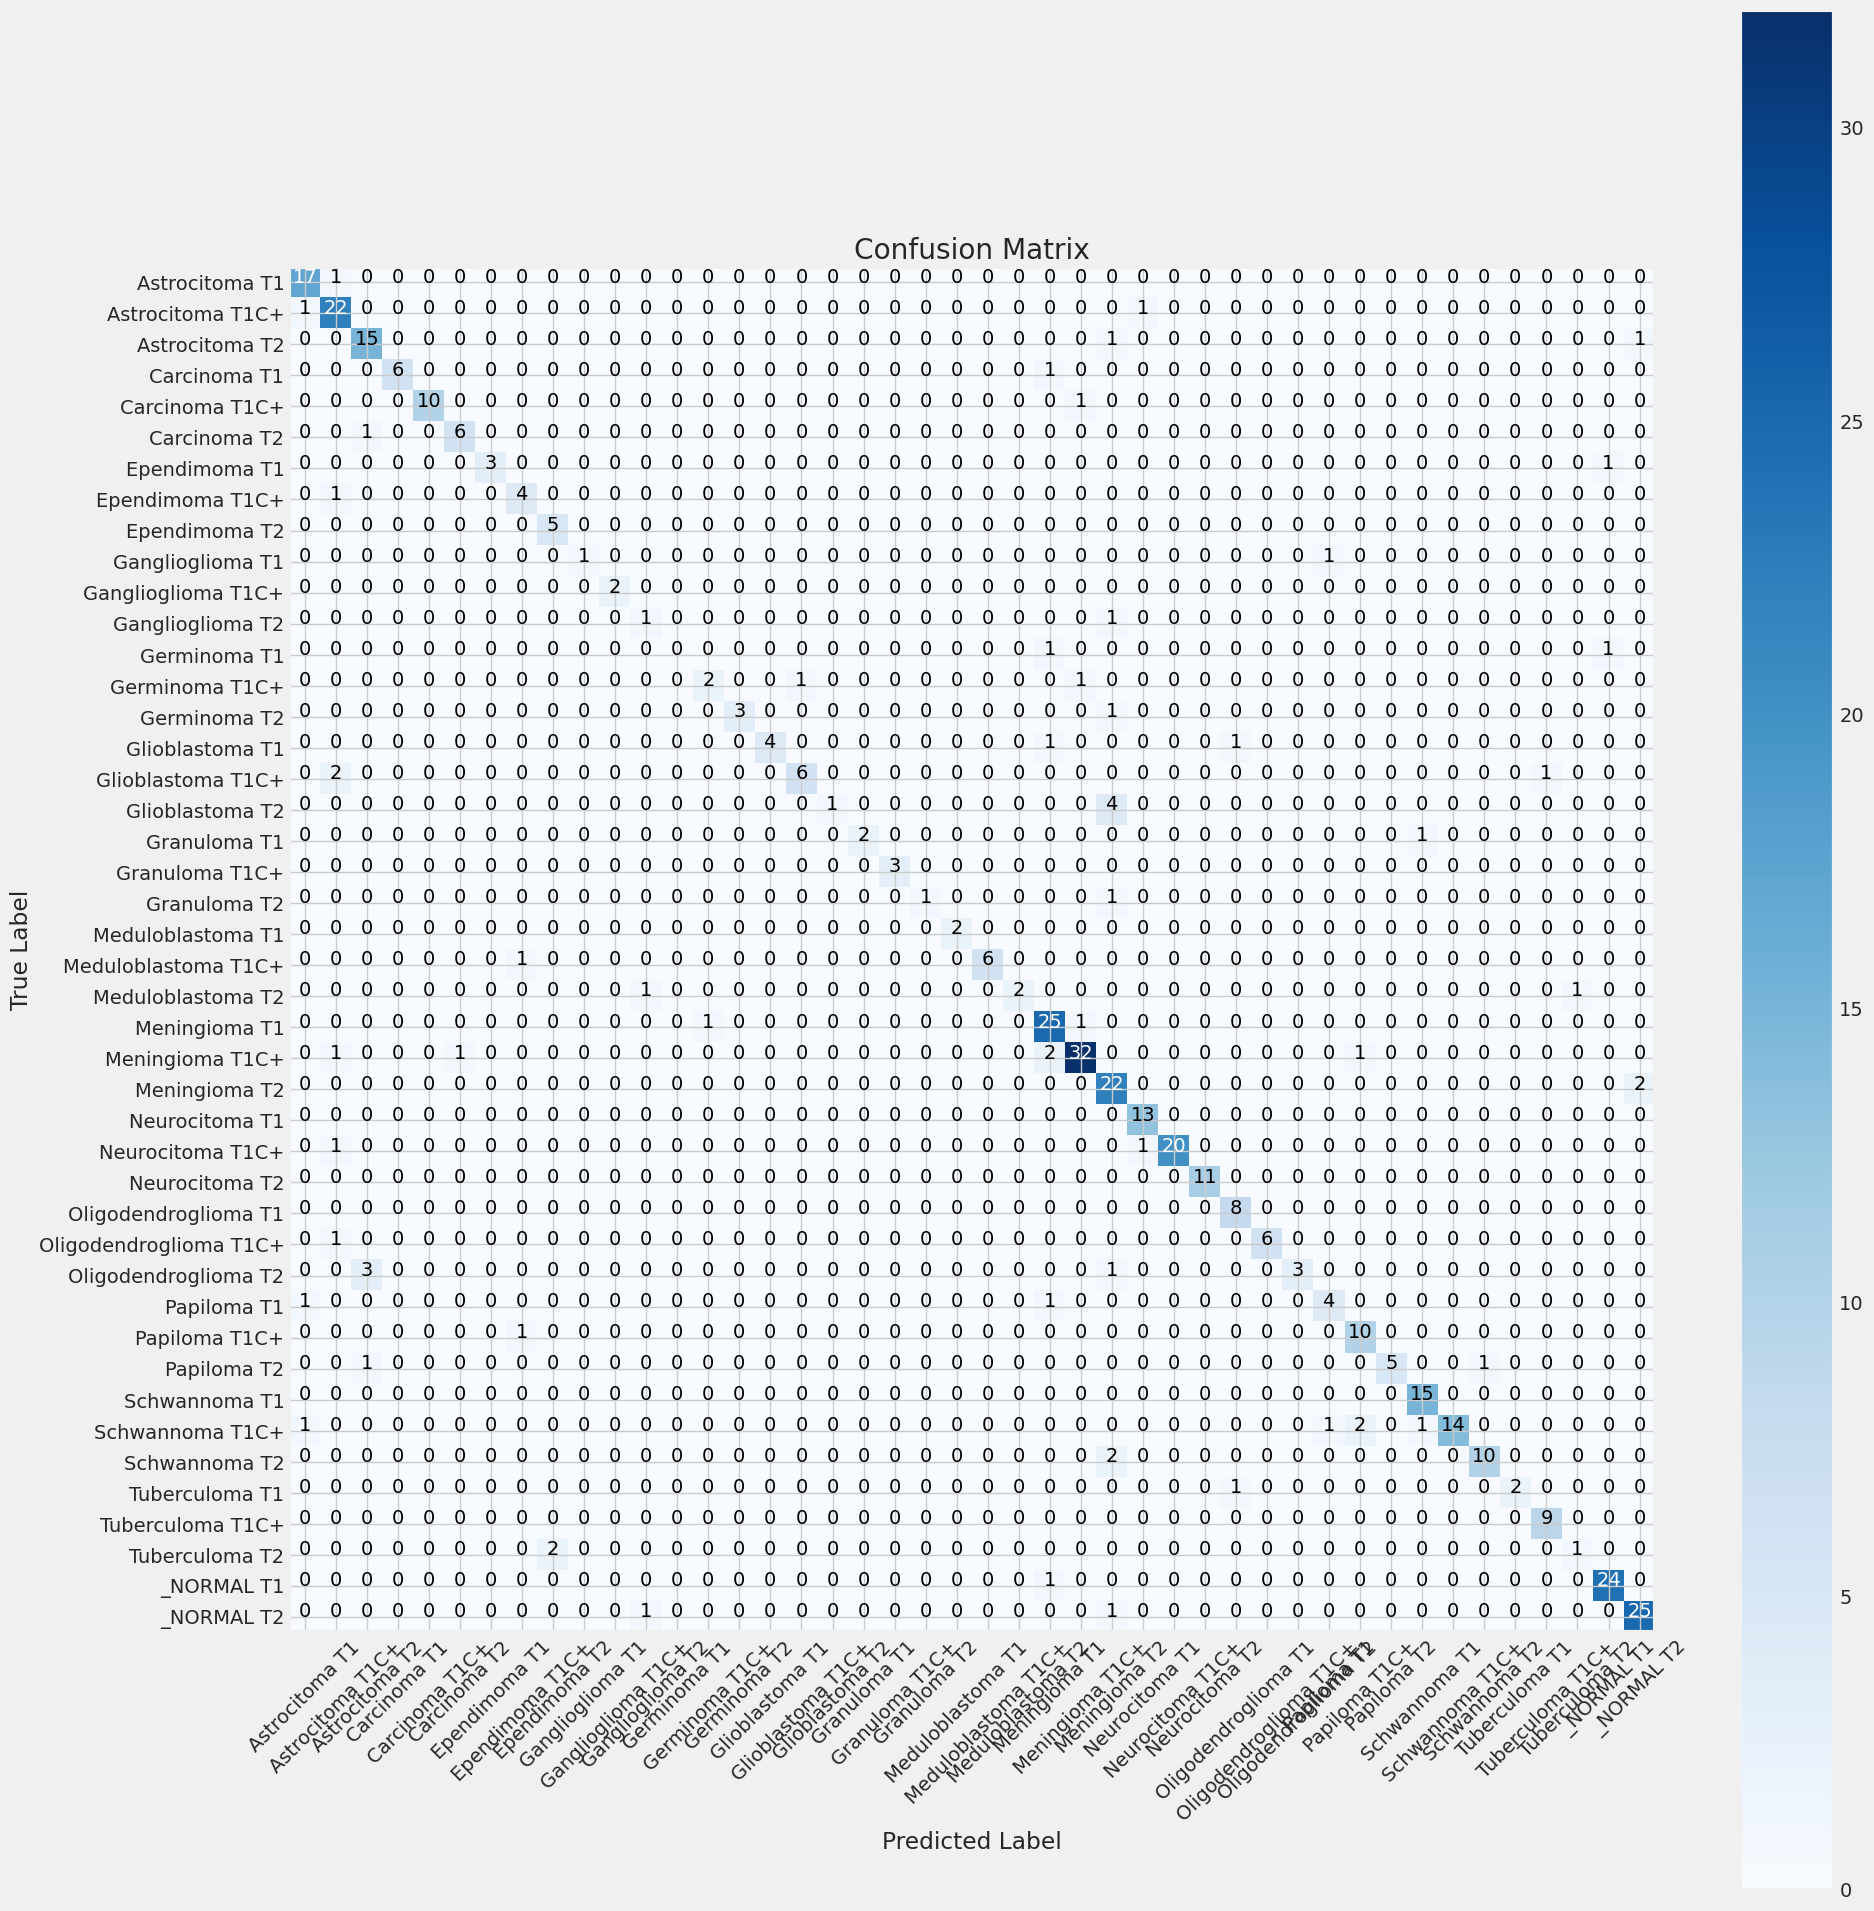

In [20]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm=cm, classes=classes, title='Confusion Matrix')

# Classification report
report = classification_report(test_gen.classes, y_pred, target_names=classes, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv('classification_report_DenseNet201.csv')
print(df)

In [21]:
model_path = 'DenseNet201'

# Create the directory if it does not exist
if not os.path.exists(model_path):
    os.makedirs(model_path)

# Save the model in SavedModel format
tf.saved_model.save(model, model_path)

KeyboardInterrupt: 

In [21]:
!zip -r DenseNet201.zip /kaggle/working/DenseNet201

  adding: kaggle/working/DenseNet201/ (stored 0%)
  adding: kaggle/working/DenseNet201/saved_model.pb (deflated 91%)
  adding: kaggle/working/DenseNet201/variables/ (stored 0%)
  adding: kaggle/working/DenseNet201/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: kaggle/working/DenseNet201/variables/variables.index (deflated 76%)
  adding: kaggle/working/DenseNet201/assets/ (stored 0%)
  adding: kaggle/working/DenseNet201/fingerprint.pb (stored 0%)


In [ ]:
test_data = tf.keras.utils.image_dataset_from_directory("/kaggle/input/tomato/New Plant Diseases Dataset(Augmented)/valid/",
                                                        labels=None, label_mode=None, color_mode='rgb',
                                                        image_size=(224,224), shuffle=False)

In [ ]:
preds = model.predict_generator(test_data)
y_pred = np.argmax(preds, axis=1)
y_pred

In [24]:
predictions = []

for i in list(y_pred):
    if i == 0:
        predictions.append('Tomato___Bacterial_spot')
        
    elif i == 1:
        predictions.append('Tomato___Early_blight')
    
    elif i == 2:
        predictions.append('Tomato___Late_blight')
        
    elif i == 3:
        predictions.append('Tomato___Leaf_Mold')
        
    elif i == 4:
        predictions.append('Tomato___Septoria_leaf_spot')
        
    elif i == 5:
        predictions.append('Tomato___Spider_mites Two-spotted_spider_mite')
        
    elif i == 6:
        predictions.append('Tomato___Target_Spot')
        
    elif i == 7:
        predictions.append('Tomato___Tomato_Yellow_Leaf_Curl_Virus')
        
    elif i == 8:
        predictions.append('Tomato___Tomato_mosaic_virus')
        
    elif i == 9:
        predictions.append('Tomato___healthy')


In [25]:
predictions[3000:4000]

['Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
 'Tomato___Target_Spot',
